# **Tarea a Resolver** ⛄

1. Bajar dataset
2. Particionar y preprocesar (considere que es una serie de tiempo)
3. Entrenar ARIMA (Hiperparámetros seleccionados usando ACF y PACF)
4. Reportar errores de entrenamiento y validación (generalización)

**Nota: Es valido usar bibliotecas para todo lo necesario en la práctica**

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
elctricidad = pd.read_csv("/content/consumo_electricidad.csv")
print(elctricidad)

           Fecha  Consumo_Electricidad
0     2020-01-01            506.927401
1     2020-01-02            496.326312
2     2020-01-03            495.324197
3     2020-01-04            502.001669
4     2020-01-05            503.787590
...          ...                   ...
1090  2022-12-26            554.986555
1091  2022-12-27            544.398296
1092  2022-12-28            550.527186
1093  2022-12-29            552.645713
1094  2022-12-30            554.498254

[1095 rows x 2 columns]


In [ ]:
#Haciendo estacioanria la serie de tiempo
columnas_a_escalas = ['Consumo_Electricidad']
datos_a_escalas = elctricidad[columnas_a_escalas]
escalador = StandardScaler()
datos_escalados = escalador.fit_transform(datos_a_escalas)
df_escalado = pd.DataFrame(datos_escalados, columns=columnas_a_escalas)
elctricidad_diferenciado = df_escalado.diff().dropna()

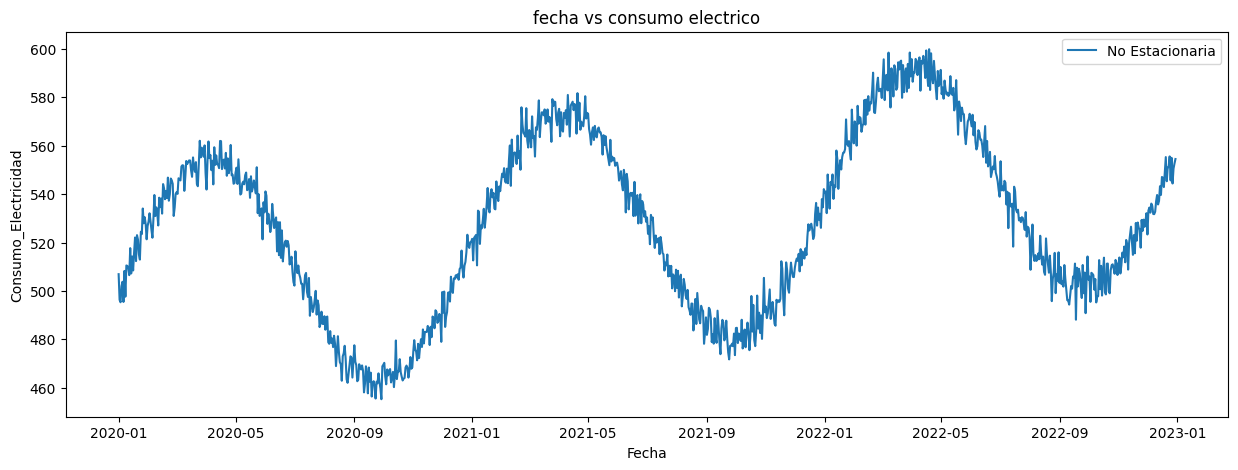

In [ ]:
elctricidad['Fecha'] = pd.to_datetime(elctricidad['Fecha'])
_fig_, _axs_ = plt.subplots(nrows = 1, figsize = (15, 5))
_fig_.subplots_adjust(hspace = 0.3, wspace = 0.3)
_axs_.set(title = "fecha vs consumo electrico")
_ = sns.lineplot(x = elctricidad["Fecha"], y = elctricidad['Consumo_Electricidad'], label = "No Estacionaria", ax = _axs_)

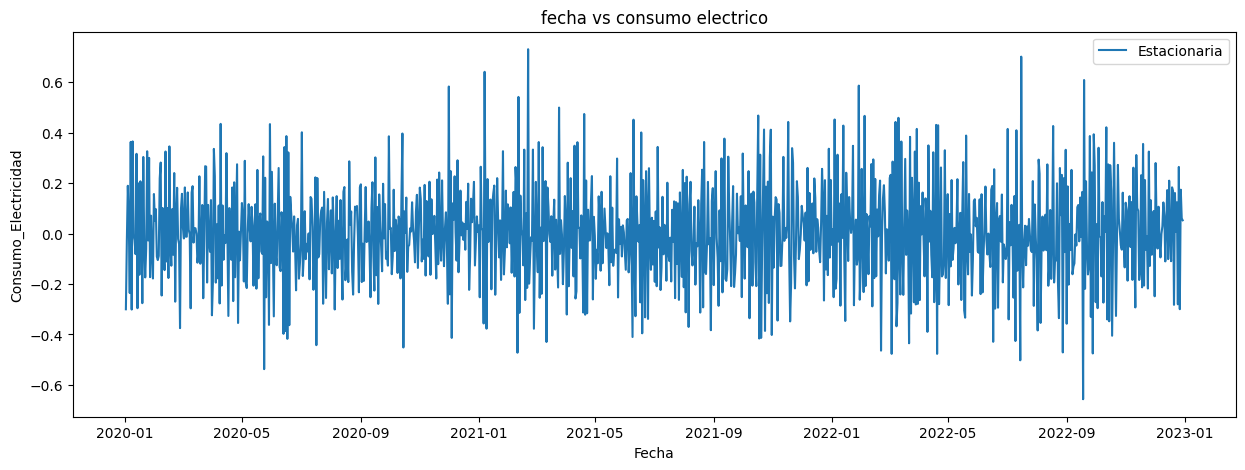

In [ ]:
elctricidad['Fecha'] = pd.to_datetime(elctricidad['Fecha'])
_fig_, _axs_ = plt.subplots(nrows = 1, figsize = (15, 5))
_fig_.subplots_adjust(hspace = 0.3, wspace = 0.3)
_axs_.set(title = "fecha vs consumo electrico")
_ = sns.lineplot(x = elctricidad["Fecha"], y = elctricidad_diferenciado['Consumo_Electricidad'], label = "Estacionaria", ax = _axs_)

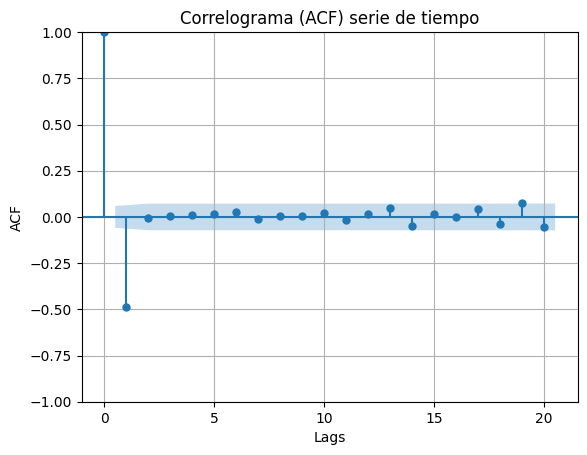

In [ ]:
#CAF Para determinar q (MA) nos damos cuenta que nos interesa un orden 2
plot_acf(elctricidad_diferenciado['Consumo_Electricidad'], lags = 20)

plt.title('Correlograma (ACF) serie de tiempo')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

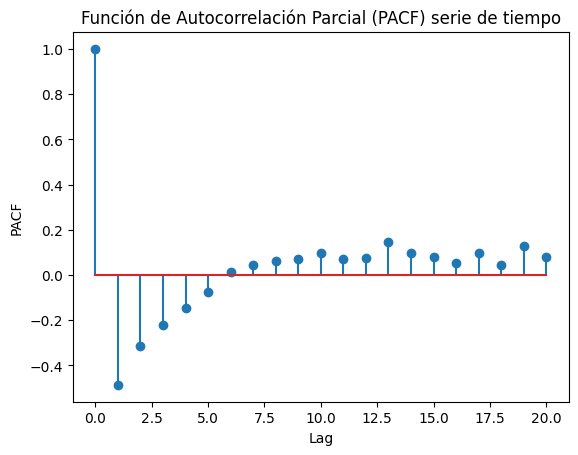

In [ ]:
#p=6 de AR
acf_array, confint = sm.tsa.pacf(elctricidad_diferenciado['Consumo_Electricidad'], nlags=20, alpha=0.05)

plt.stem(acf_array)
plt.title('Función de Autocorrelación Parcial (PACF) serie de tiempo')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

In [ ]:
#Vamos a ocupar 895 datos de prueba
train = np.array(elctricidad_diferenciado['Consumo_Electricidad'].iloc[0:895].values)
test = np.array(elctricidad_diferenciado['Consumo_Electricidad'].iloc[895:1095].values)

In [ ]:
#ARIMA(p, d, q)
#Para este caso "d" tiene un valor de 0 debido a que anteriormente se hizo estacionaria la serie de tiempo
modelo_ARIMA = sm.tsa.arima.ARIMA(train, order=(6, 0, 2))
res = modelo_ARIMA.fit(cov_type = 'opg')
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  895
Model:                 ARIMA(6, 0, 2)   Log Likelihood                 410.711
Date:                Fri, 08 Dec 2023   AIC                           -801.421
Time:                        02:32:55   BIC                           -753.453
Sample:                             0   HQIC                          -783.092
                                - 895                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0104      0.011      0.980      0.327      -0.010       0.031
ar.L1          0.0863      0.186      0.463      0.643      -0.279       0.451
ar.L2          0.1538      0.048      3.202      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#Las siguientes 100 predicciones
forecast_pasos= 200
forecast = res.get_forecast(steps=forecast_pasos)

#valores pronosticados e intervalos de confianza
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
print(f"Tipo de resultado {type(forecast_mean)} y el tamaño {np.shape(forecast_mean)}")

Tipo de resultado <class 'numpy.ndarray'> y el tamaño (200,)


In [ ]:
predicciones = np.hstack((train, forecast_mean))
print(f"Tamaño de predicciones {np.shape(predicciones)}")

Tamaño de predicciones (1095,)


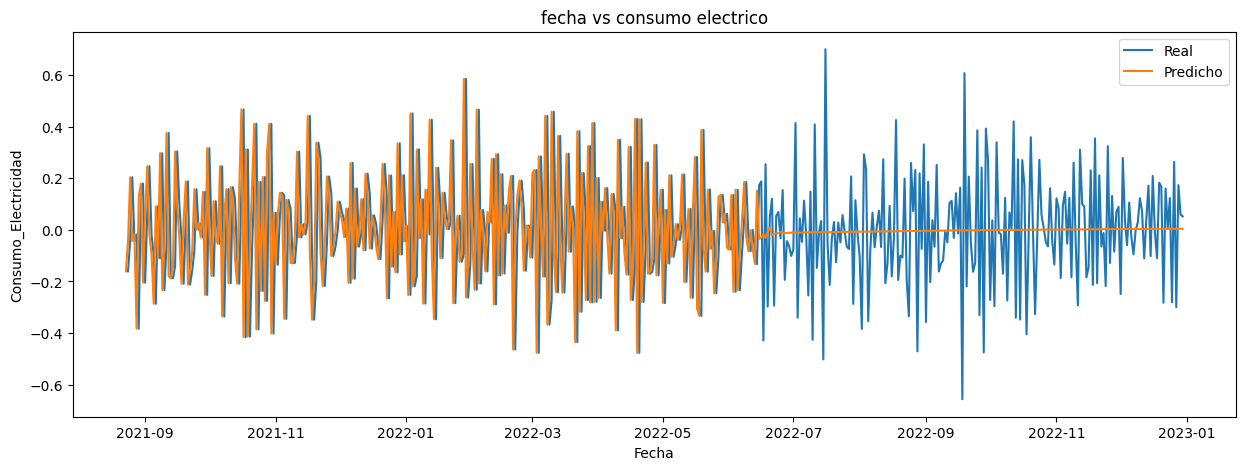

In [ ]:
elctricidad['Fecha'] = pd.to_datetime(elctricidad['Fecha'])
_fig_, _axs_ = plt.subplots(nrows = 1, figsize = (15, 5))
_fig_.subplots_adjust(hspace = 0.3, wspace = 0.3)
_axs_.set(title = "fecha vs consumo electrico")
_ = sns.lineplot(x = elctricidad["Fecha"].iloc[601:].values, y = elctricidad_diferenciado['Consumo_Electricidad'].iloc[600:], label = "Real", ax = _axs_)
_ = sns.lineplot(x = elctricidad["Fecha"].iloc[600:], y = predicciones[600:], label = "Predicho", ax = _axs_)

In [ ]:
data = np.array(elctricidad_diferenciado['Consumo_Electricidad'].values)


print(f"Tipo {type(data)} tamaño {np.shape(data)}")

Tipo <class 'numpy.ndarray'> tamaño (1094,)


In [ ]:

train_predictions = res.predict(start=0, end=len(train)-1, dynamic=False)

test_predictions = res.predict(start=len(train), end=len(data)-1, dynamic=False)

train_rmse = mean_squared_error(train, train_predictions, squared=False)

test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Reportar errores
print(f"Error de entrenamiento (RMSE): {train_rmse}")
print(f"Error de prueba (RMSE): {test_rmse}")

Error de entrenamiento (RMSE): 0.15302238371854682
Error de prueba (RMSE): 0.21494128308744784
